In [5]:
import pandas as pd
import numpy as np
import re

In [7]:
# Desired labels
ORDERED_LABELS = [
    "Control (34.0 g/L)",
    "36.4 g/L",
    "45.8 g/L",
    "51.8 g/L",
    "57.7 g/L",
]

SALINITY_BY_PERCENT = {
    0: "Control (34.0 g/L)",
    10: "36.4 g/L",
    50: "45.8 g/L",
    75: "51.8 g/L",
    100: "57.7 g/L",
}

SALINITY_BY_VALUE = {
    34.0: "Control (34.0 g/L)",
    36.4: "36.4 g/L",
    45.8: "45.8 g/L",
    51.8: "51.8 g/L",
    57.7: "57.7 g/L",
}


In [8]:
# ---------- Helpers ----------
def _standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = {c: re.sub(r"\s+", " ", str(c)).strip() for c in df.columns}
    df = df.rename(columns=new_cols)
    return df

def _find_col(df: pd.DataFrame, candidates, must_contain=None):
    # Try exact matches first
    for cand in candidates:
        if cand in df.columns:
            return cand
    # Fallback: fuzzy match by substring (case-insensitive)
    if must_contain:
        patt = re.compile(must_contain, flags=re.I)
        for c in df.columns:
            if patt.search(c):
                return c
    # Last resort: case-insensitive equality
    low_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in low_map:
            return low_map[cand.lower()]
    return None

def _to_float_maybe(x):
    try:
        return float(str(x).replace(",", ".").strip())
    except Exception:
        return np.nan

def map_treatment_value(val):
    """Map raw Treatment value to the requested label."""
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()

    # If it already looks like one of the target labels, normalize spacing
    for label in ORDERED_LABELS:
        if s == label.lower():
            return label

    # Control keywords
    if "control" in s or "ctrl" in s:
        return "Control (34.0 g/L)"

    # Percent forms like "10%", "75 %"
    m = re.search(r"(\d+)\s*%$", s)
    if m:
        p = int(m.group(1))
        return SALINITY_BY_PERCENT.get(p, val)

    # Numeric salinity present in string
    # Try to catch numbers like "36.4", "36,4", "g/L", etc.
    m2 = re.search(r"(\d+[.,]?\d*)", s)
    if m2:
        num = _to_float_maybe(m2.group(1))
        if not np.isnan(num):
            # Snap to closest of the known salinities if within a tolerance
            known_vals = list(SALINITY_BY_VALUE.keys())
            diffs = [abs(num - kv) for kv in known_vals]
            idx = int(np.argmin(diffs))
            if diffs[idx] <= 0.3:  # tolerance
                return SALINITY_BY_VALUE[known_vals[idx]]

    # Pure numeric value
    num = _to_float_maybe(val)
    if not np.isnan(num):
        known_vals = list(SALINITY_BY_VALUE.keys())
        diffs = [abs(num - kv) for kv in known_vals]
        idx = int(np.argmin(diffs))
        if diffs[idx] <= 0.3:
            return SALINITY_BY_VALUE[known_vals[idx]]

    # Otherwise return as-is (will appear at end, can be inspected)
    return str(val)

In [4]:
df_data = pd.read_csv("../raw_data/mortality_final_bioassay.csv")
df_data

,Treatment,Day,Reply,Dead,Accumulated dead per reply,% Mortality
0,57.7,28,1,0,10,100
1,57.7,28,2,0,10,100
2,57.7,28,3,0,10,100
3,51.8,28,1,0,6,60
4,51.8,28,2,0,9,90
5,51.8,28,3,0,7,70
6,45.8,28,1,0,0,0
7,45.8,28,2,0,1,10
8,45.8,28,3,0,2,20
9,36.4,28,1,0,0,0


In [15]:
# Clean column names
df = _standardize_columns(df_data)

# Identify columns
treatment_col = _find_col(df, ["Treatment"], must_contain="treat")
mortality_col = _find_col(df, ["% Mortality", "Mortality %"], must_contain="mortality")

if treatment_col is None or mortality_col is None:
    raise ValueError(
        f"Could not find required columns. Found columns: {list(df.columns)}\n"
        f"Treatment col: {treatment_col} | Mortality col: {mortality_col}"
    )

# Map Treatment values to the target labels
df["Treatment_Label"] = df[treatment_col].apply(map_treatment_value)

# Ensure mortality is numeric
df["Mortality_pct"] = pd.to_numeric(df[mortality_col], errors="coerce")

# Group and aggregate
summary = (
    df.groupby("Treatment_Label", dropna=False)["Mortality_pct"]
    .agg(N="count", Mean="mean", SD="std")
    .reset_index()
)

# Order rows according to desired labels, then any leftovers
cat_type = pd.CategoricalDtype(categories=ORDERED_LABELS, ordered=True)
summary["Treatment_Label"] = summary["Treatment_Label"].astype(cat_type)
summary = summary.sort_values("Treatment_Label")

# Round values
summary["Mean % Mortality"] = summary["Mean"].round(2)
summary["SD % Mortality"] = summary["SD"].round(2)

# Select and rename columns
summary = summary[["Treatment_Label", "N", "Mean % Mortality", "SD % Mortality"]]
summary = summary.rename(columns={"Treatment_Label": "Treatment"})

summary

,Treatment,N,Mean % Mortality,SD % Mortality
4,Control (34.0 g/L),3,3.33,5.77
0,36.4 g/L,3,3.33,5.77
1,45.8 g/L,3,10.00,10.00
2,51.8 g/L,3,73.33,15.28
3,57.7 g/L,3,100.00,0.00


In [16]:
summary.to_csv("../data_for_plots/mortality/final_bioassay_data.csv", index=False)

In [17]:
summary.columns

Index(['Treatment', 'N', 'Mean % Mortality', 'SD % Mortality'], dtype='object')

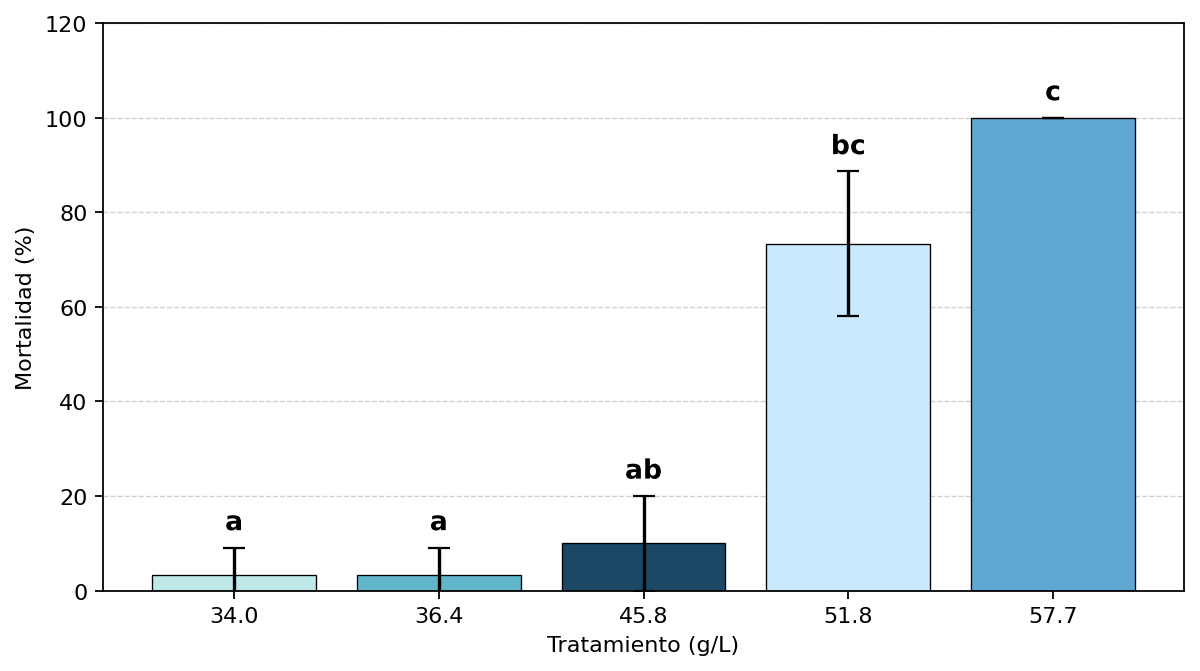

Guardado: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/notebook_analysis/mortality_barplot_from_summary.png y /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/notebook_analysis/mortality_barplot_from_summary.pdf


In [18]:
# plot_mortality_from_summary.py
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# ---- Config ----
OUT_PNG = "mortality_barplot_from_summary.png"
OUT_PDF = "mortality_barplot_from_summary.pdf"

ORDERED_LABELS = [
    "Control (34.0 g/L)", "36.4 g/L", "45.8 g/L", "51.8 g/L", "57.7 g/L"
]
# Paleta en el MISMO orden
personalized_pallete = ["#bee9e8", "#62b6cb", "#1b4965", "#cae9ff", "#5fa8d3"]

# Letras por tratamiento (en el mismo orden). Cambia si lo necesitas.
DEFAULT_LETTERS = ["a", "a", "ab", "bc", "c"]

# ---- Helpers ----
def salinity_from_label(label: str) -> float:
    if "Control" in label:
        return 34.0
    m = re.search(r"(\d+[.,]?\d*)", label)
    return float(m.group(1).replace(",", ".")) if m else np.nan

# ---- Load summary ----
df = summary
# Espera columnas: Treatment | N | Mean % Mortality | SD % Mortality
df = df[df["Treatment"].isin(ORDERED_LABELS)].copy()
df["Treatment"] = pd.Categorical(df["Treatment"], categories=ORDERED_LABELS, ordered=True)
df = df.sort_values("Treatment")
df["Salinity_gL"] = df["Treatment"].apply(salinity_from_label)

# Letras (si tu CSV tuviera una columna 'Letters', la usamos; si no, usamos las default)
if "Letters" in df.columns:
    letters_map = dict(zip(df["Treatment"], df["Letters"]))
else:
    letters_map = dict(zip(ORDERED_LABELS, DEFAULT_LETTERS))

# ---- Plot ----
x = np.arange(len(df))
means = df["Mean % Mortality"].to_numpy(float)
sds   = df["SD % Mortality"].to_numpy(float)
colors = [dict(zip(ORDERED_LABELS, personalized_pallete))[lab] for lab in df["Treatment"]]

plt.figure(figsize=(7.6, 4.3), dpi=160)
bars = plt.bar(x, means, yerr=sds, capsize=5, edgecolor="black", linewidth=0.6, color=colors)

plt.xticks(x, [f"{s:.1f}" for s in df["Salinity_gL"]])
plt.xlabel("Tratamiento (g/L)")
plt.ylabel("Mortalidad (%)")

ymax = max(100.0, np.nanmax(means + np.nan_to_num(sds)) * 1.20)
plt.ylim(0, ymax)
ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)

# Letras encima de la punta de la barra de error, con halo blanco
offset = 0.02 * ymax
for xi, lab, m, sd in zip(x, df["Treatment"], means, sds):
    txt = letters_map.get(lab, "")
    ytxt = (m + (sd if not np.isnan(sd) else 0.0)) + offset
    ax.text(xi, ytxt, txt, ha="center", va="bottom",
            fontsize=12, fontweight="bold", color="black",
            path_effects=[pe.withStroke(linewidth=2.5, foreground="white")])

plt.tight_layout()
plt.savefig(OUT_PNG, bbox_inches="tight", dpi=300)
plt.savefig(OUT_PDF, bbox_inches="tight")
plt.show()
print(f"Guardado: {Path(OUT_PNG).resolve()} y {Path(OUT_PDF).resolve()}")
